## Model 1: Logistic Regression, original dataset

With original dataset

Shape: (6362620, 12)

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix


In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [3]:
## loading data
df = pd.read_csv('fraud_detection.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
## separating variables
num_col=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
cat_col = ['type','nameOrig','nameDest']
encoded_col = ['isFraud','isFlaggedFraud']

## Cleaning the dataset

In [6]:
##dropping 'nameOrig' and 'nameDest' as they are ID's of the sender and recipient which are not useful for the model
df.drop(['nameOrig','nameDest'],axis=1,inplace=True)

In [7]:
## replacing outliers with median 

for col in num_col:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    UB = Q3 + 1.5* IQR #1280.25 upper bound for outliers
    LB = Q1 - 1.5* IQR #lowe upper bound for outliers
    df[col] = np.where(df[col] > UB, int(df[col].median()),df[col])
    df[col] = np.where(df[col] < LB, int(df[col].median()),df[col])
    #df.drop(df[df[col] < LB].index, inplace=True)
    #df.drop(df[df[col] > UB].index, inplace=True)

In [8]:
df.shape #after dropping outliers: (3199292, 9) about half rows have been removed

(6362620, 9)

In [9]:
## One-hot encoding on 'type' column to turn it into numerical values, instead of label encoding 
## too avoid the model misunderstand the data to be in some kind of order, 0 < 1 <2
df=pd.get_dummies(data=df,columns=['type'],drop_first=True)

## changing booleans of encoded 'type' data to 0/1
zero_one = {False:0, True:1}
type_encoded = ['type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER']
for i in type_encoded:
    df[i] = df[i].map(zero_one)

In [10]:
## moving target variable'isFraud' as the last column to split easier intp train, split later on
df = df[ [ col for col in df.columns if col != 'isFraud' ] + ['isFraud'] ]

In [11]:
# We are using RobustScaler to scale down the numerical features as RobustScaler is less prone to outliers
scale = RobustScaler()
for feature in num_col:
    df[feature]=scale.fit_transform(df[feature].values.reshape(-1, 1))
df.head()

## on the first row, we can still see that there's a huge range even after scaling -1.36 to 32.44
## could try another scaler

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,-1.36,-0.402548,6.251373,32.449247,-0.320668,-0.38925,0,0,0,1,0,0
1,-1.36,-0.451916,0.282284,3.924104,-0.320668,-0.38925,0,0,0,1,0,0
2,-1.36,-0.462336,-0.562362,0.000000,-0.320668,-0.38925,0,0,0,0,1,1
3,-1.36,-0.462336,-0.562362,0.000000,-0.269484,-0.38925,0,1,0,0,0,1
4,-1.36,-0.391230,1.096340,6.049879,-0.320668,-0.38925,0,0,0,1,0,0


In [12]:
## the cleaned data
df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,-1.36,-0.402548,6.251373,32.449247,-0.320668,-0.389250,0,0,0,1,0,0
1,-1.36,-0.451916,0.282284,3.924104,-0.320668,-0.389250,0,0,0,1,0,0
2,-1.36,-0.462336,-0.562362,0.000000,-0.320668,-0.389250,0,0,0,0,1,1
3,-1.36,-0.462336,-0.562362,0.000000,-0.269484,-0.389250,0,1,0,0,0,1
4,-1.36,-0.391230,1.096340,6.049879,-0.320668,-0.389250,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,0.00,1.639197,0.000000,0.000000,-0.320668,0.226704,0,1,0,0,0,1
6362616,0.00,0.000000,0.000000,0.000000,-0.320668,-0.389250,0,0,0,0,1,1
6362617,0.00,0.000000,0.000000,0.000000,-0.155172,0.000000,0,1,0,0,0,1
6362618,0.00,0.000000,0.000000,0.000000,-0.320668,-0.389250,0,0,0,0,1,1


## Split data intro train and test

In [13]:
## select dep and indep 
X = df.iloc[:,:-1].values 
y = df.iloc[:,-1].values

# spplit into train test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=32) 

## Model logistic regression

In [14]:
## build logistic regression model: will take a while since we have over 6million records
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

## make prediction
y_pred = log_reg.predict(X_test)


## Evaluation

In [15]:
# check accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9987308687301772


In [16]:
## classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270908
           1       1.00      0.00      0.00      1616

    accuracy                           1.00   1272524
   macro avg       1.00      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



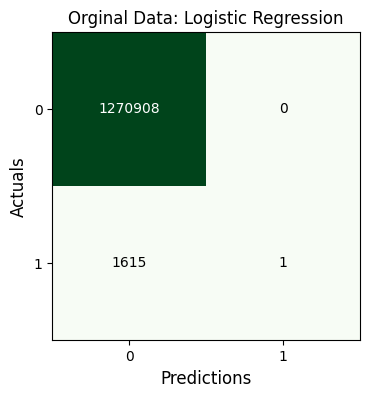

In [17]:
#confusion matrix

logr_conf_mat = confusion_matrix(y_test, y_pred)
logr_conf_mat

fig, ax = plot_confusion_matrix(conf_mat = logr_conf_mat , figsize = (4,4), cmap = 'Greens')
plt.xlabel('Predictions', fontsize = 12 )
plt.ylabel('Actuals', fontsize = 12 )
plt.title('Orginal Data: Logistic Regression', fontsize = 12 )
plt.show()

## the model is very good at predicting non-fraud, but very bad at recognising frauded transactions that go unflagged (1615).
## this is model is the same as the original system that is not good at flagging fraud transactions


AUC: 0.500309


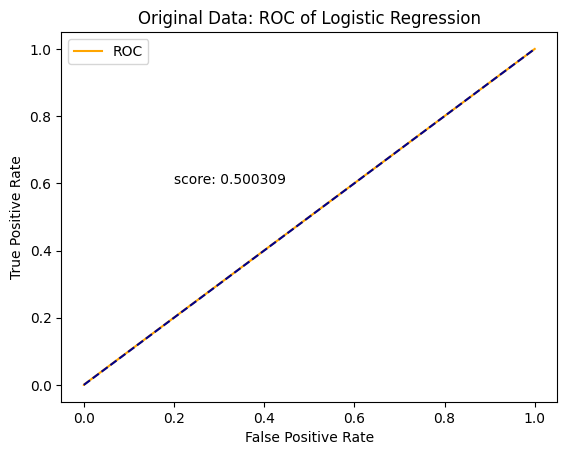

In [18]:
## Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %f' %auc)


fpr, tpr = roc_curve(y_test, y_pred)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Original Data: ROC of Logistic Regression')
plt.text(y= 0.6, x=0.2, s=f'score: {round(auc,6)}')
plt.legend()
plt.show()

## Conclusion

Although the accuracy is at 99.8%, from the confusion matrix, this model is no better than the current system that the bank is using. 

Due to the imblance dataset, the model can only recognise non-fraud transactions and cannot recognise actual fraud transactions at all.

The ROC at 0.5 shows that this model is just randomly guessing transactions.

Here the model is overfitting.
